In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BarycentricInterpolator

In [7]:

def solve_H_onestep(H_j, K, Ss, dt, dz, alpha, q, H_riv, H_aq, A=None, M_exp=None):
    """
    Calcule l'état du vecteur de charge hydraulique H au temps j+1 à partir de l'état au temps j,
    en incluant un terme source/puits q.

    Cette fonction résout le système linéaire A * H^{j+1} = M_exp * H^j + Q_source pour H^{j+1}.
    Si les matrices A et M_exp ne sont pas fournies, elle les calcule et les renvoie
    pour une utilisation ultérieure.

    Arguments:
    ----------
    H_j : np.ndarray
        Vecteur des charges hydrauliques au temps j. De taille (Nz,). Unité : [m].
    K : float
        Conductivité hydraulique du milieu. Unité : [m/s].
    Ss : float
        Emmagasinement spécifique du milieu. Unité : [m⁻¹].
    dt : float
        Pas de temps. Unité : [s].
    dz : float
        Pas d'espace (discrétisation verticale). Unité : [m].
    alpha : float
        Paramètre de pondération du schéma (0=explicite, 0.5=Crank-Nicolson, 1=implicite). Sans dimension.
    q : np.ndarray or float
        Terme source/puits. Un q positif correspond à un apport d'eau.
        Peut être un scalaire (source uniforme) ou un vecteur de taille (Nz,) (source variable en profondeur).
        Unité : [s⁻¹].
    H_riv : float
        Condition aux limites de Dirichlet à la frontière supérieure (rivière). Unité : [m].
    H_aq : float
        Condition aux limites de Dirichlet à la frontière inférieure (aquifère). Unité : [m].
    A : np.ndarray, optionnel
        Matrice implicite du système (côté gauche). Si None, elle est calculée.
    M_exp : np.ndarray, optionnel
        Matrice explicite du système (côté droit). Si None, elle est calculée.

    Retourne:
    ---------
    H_j_plus_1 : np.ndarray
        Vecteur des charges hydrauliques calculé au temps j+1. Unité : [m].
    A : np.ndarray
        Matrice implicite A, calculée si elle n'était pas fournie.
    M_exp : np.ndarray
        Matrice explicite M_exp, calculée si elle n'était pas fournie.
    """
    
    # Récupération de la taille du problème à partir du vecteur d'entrée H_j
    Nz = len(H_j)

    # --- Étape 1 : Calcul des matrices si elles ne sont pas fournies ---
    if A is None or M_exp is None:
        
        # Calcul du coefficient adimensionnel beta (nombre de Fourier numérique)
        # Il régit la diffusion de la charge dans la grille.
        # Vérification des unités : beta = (K * dt) / (Ss * dz^2)
        # [m/s * s] / [m⁻¹ * m²] = [m] / [m] = Sans dimension. L'expression est homogène. ✅
        beta = (K * dt) / (Ss * dz**2)
        
        # Initialisation des matrices avec des zéros de taille (Nz x Nz)
        A = np.zeros((Nz, Nz))
        M_exp = np.zeros((Nz, Nz))

        # Remplissage pour les nœuds INTERNES (de l'indice 1 à Nz-2)
        for i in range(1, Nz - 1):
            # Matrice A (implicite, associée aux inconnues H^{j+1})
            A[i, i - 1] = -alpha * beta
            A[i, i]     = 1 + 2 * alpha * beta
            A[i, i + 1] = -alpha * beta
            
            # Matrice M_exp (explicite, associée aux valeurs connues H^j)
            M_exp[i, i - 1] = (1 - alpha) * beta
            M_exp[i, i]     = 1 - 2 * (1 - alpha) * beta
            M_exp[i, i + 1] = (1 - alpha) * beta

        # --- Application des conditions aux limites de Dirichlet sur les MATRICES ---
        # Pour le nœud supérieur (i=0), H_0^{j+1} = H_riv
        A[0, 0] = 1
        # Pour le nœud inférieur (i=Nz-1), H_{Nz-1}^{j+1} = H_aq
        A[Nz - 1, Nz - 1] = 1

    # --- Étape 2 : Calcul du vecteur second membre (côté droit de l'équation) ---
    # B = M_exp * H^j + terme_source
    
    # Calcul de la partie liée à l'état précédent
    B = M_exp @ H_j

    # Ajout de la contribution du terme source q
    # Le terme (q * dt / Ss) représente la variation de charge [m] due à la source.
    # Vérification des unités : [s⁻¹] * [s] / [m⁻¹] = [1] / [m⁻¹] = [m]. C'est homogène. ✅
    source_contribution = (q * dt) / Ss
    B = B + source_contribution
    
    # Application des conditions aux limites de Dirichlet au vecteur B
    # On force la valeur de la charge aux frontières après tous les autres calculs.
    B[0] = H_riv
    B[Nz - 1] = H_aq

    # --- Étape 3 : Résolution du système linéaire ---
    # On résout le système A * H^{j+1} = B pour trouver H^{j+1}
    H_j_plus_1 = np.linalg.solve(A, B)
    
    # --- Étape 4 : Retourner les résultats ---
    return H_j_plus_1, A, M_exp

In [12]:
import numpy as np

def solve_T_onestep(T_j, q_darcy, q_v, 
                    rho_m_cm, rho_w_cw, lambda_m,
                    dt, dz, alpha, 
                    T_riv, T_aq, 
                    A=None, M_exp=None):
    """
    Calcule le profil de température T au temps j+1 à partir de l'état au temps j.

    Cette fonction résout l'équation de transport de chaleur en 1D (advection-conduction)
    en utilisant un schéma de Crank-Nicolson pondéré (alpha-implicite).
    Equation résolue :
    rho_m*c_m * dT/dt = -rho_w*c_w * q * dT/dz + lambda_m * d²T/dz² + rho_w*c_w*q_v*T

    Arguments:
    ----------
    T_j : np.ndarray
        Vecteur des températures au temps j. De taille (Nz,). Unité : [K].
    q_darcy : np.ndarray
        Vecteur des vitesses de Darcy le long de l'axe z. De taille (Nz,). Unité : [m/s].
        Un q_darcy positif représente un écoulement vers les z croissants.
    q_v : np.ndarray or float
        Terme source/puits de fluide. Un q_v positif correspond à un apport de fluide.
        Peut être un scalaire ou un vecteur de taille (Nz,). Unité : [s⁻¹].
    rho_m_cm : float
        Capacité thermique volumique du milieu poreux équivalent (solide+eau). Unité : [J·m⁻³·K⁻¹].
    rho_w_cw : float
        Capacité thermique volumique de l'eau. Unité : [J·m⁻³·K⁻¹].
    lambda_m : float
        Conductivité thermique du milieu poreux équivalent. Unité : [W·m⁻¹·K⁻¹] ou [J·s⁻¹·m⁻¹·K⁻¹].
    dt : float
        Pas de temps. Unité : [s].
    dz : float
        Pas d'espace vertical. Unité : [m].
    alpha : float
        Paramètre de pondération du schéma (0.5 pour Crank-Nicolson). Sans dimension.
    T_riv : float
        Condition aux limites de Dirichlet à la surface (température de la rivière). Unité : [K].
    T_aq : float
        Condition aux limites de Dirichlet au fond (température de l'aquifère). Unité : [K].
    A : np.ndarray, optionnel
        Matrice implicite du système. Si None, elle est calculée.
    M_exp : np.ndarray, optionnel
        Matrice explicite du système. Si None, elle est calculée.

    Retourne:
    ---------
    T_j_plus_1 : np.ndarray
        Vecteur des températures calculé au temps j+1. Unité : [K].
    A : np.ndarray
        Matrice implicite A, calculée si elle n'était pas fournie.
    M_exp : np.ndarray
        Matrice explicite M_exp, calculée si elle n'était pas fournie.
    """
    Nz = len(T_j)

    # Assurer que q_v est un vecteur de la bonne taille s'il est fourni comme un scalaire
    if isinstance(q_v, (int, float)):
        q_v = np.full(Nz, q_v)

    # --- Étape 1 : Calcul des matrices si elles ne sont pas fournies ---
    # NOTE : Si q_darcy ou q_v varient dans le temps, il faut recalculer les matrices à chaque pas.
    # La logique de réutilisation n'est valide que si q_darcy et q_v sont constants.
    if A is None or M_exp is None:
        A = np.zeros((Nz, Nz))
        M_exp = np.zeros((Nz, Nz))

        # --- Définition des coefficients pour la lisibilité ---
        # Ces coefficients adimensionnels représentent l'influence relative
        # de l'advection, de la conduction et du terme source sur un pas de temps.

        # Coeff. d'advection. Vérification unités : [J·m⁻³·K⁻¹·m·s⁻¹·s] / [J·m⁻³·K⁻¹·m] = [-] ✅
        adv_coeff = (rho_w_cw * dt) / (rho_m_cm * 2 * dz)
        
        # Coeff. de conduction (similaire à beta). Vérification unités : [W·m⁻¹·K⁻¹·s] / [J·m⁻³·K⁻¹·m²] = [J·s⁻¹·m⁻¹·s] / [J·m⁻³·m²] = [-] ✅
        cond_coeff = (lambda_m * dt) / (rho_m_cm * dz**2)
        
        # Coeff. du terme source. Vérification unités : [J·m⁻³·K⁻¹·s⁻¹·s] / [J·m⁻³·K⁻¹] = [-] ✅
        src_coeff = (rho_w_cw * dt) / rho_m_cm
        
        # Remplissage pour les nœuds INTERNES (de i=1 à Nz-2)
        for i in range(1, Nz - 1):
            # Termes pour la matrice A (implicite, temps j+1)
            # La discrétisation du gradient pour l'advection est une différence centrée.
            diag_inf_A = alpha * (adv_coeff * q_darcy[i] - cond_coeff)
            diag_princ_A = 1 + alpha * (2 * cond_coeff - src_coeff * q_v[i])
            diag_sup_A = -alpha * (adv_coeff * q_darcy[i] + cond_coeff)
            
            A[i, i - 1] = diag_inf_A
            A[i, i]     = diag_princ_A
            A[i, i + 1] = diag_sup_A

            # Termes pour la matrice M_exp (explicite, temps j)
            diag_inf_M = (1 - alpha) * (-adv_coeff * q_darcy[i] + cond_coeff)
            diag_princ_M = 1 - (1 - alpha) * (2 * cond_coeff - src_coeff * q_v[i])
            diag_sup_M = (1 - alpha) * (adv_coeff * q_darcy[i] + cond_coeff)

            M_exp[i, i - 1] = diag_inf_M
            M_exp[i, i]     = diag_princ_M
            M_exp[i, i + 1] = diag_sup_M
            
        # --- Application des conditions aux limites de Dirichlet sur les MATRICES ---
        A[0, 0] = 1.0
        A[Nz - 1, Nz - 1] = 1.0
        # M_exp a déjà des zéros sur les lignes 0 et Nz-1, ce qui est correct.

    # --- Étape 2 : Calcul du vecteur second membre ---
    # B = M_exp * T^j
    B = M_exp @ T_j

    # Application des conditions aux limites de Dirichlet sur le vecteur B
    B[0] = T_riv
    B[Nz - 1] = T_aq

    # --- Étape 3 : Résolution du système linéaire ---
    # A * T^{j+1} = B
    T_j_plus_1 = np.linalg.solve(A, B)

    # --- Étape 4 : Retourner les résultats ---
    return T_j_plus_1, A, M_exp

In [32]:
# Paramètres physiques
K = 1e-11          # Conductivité hydraulique [m/s].
Lz = 0.4           # Profondeur totale du domaine vertical [m].
n = 0.1            # Porosité du milieu [-].
Ss = n / Lz        # Emmagasinement spécifique [m⁻¹].
rho_m_cm = 4e6  # Capacité thermique volumique du milieu poreux équivalent [J·m⁻³·K⁻¹].
rho_w_cw = 4.185e6 # Capacité thermique volumique de l
lambda_m = 2.0    # Conductivité thermique du milieu poreux équivalent [W·m⁻¹·K⁻¹].

# Paramètres de la grille
Nz = 1000           # Nombre de nœuds sur la grille verticale [-].
dz = Lz / (Nz - 1) # Pas d'espace vertical [m].

# Paramètres temporels et de schéma
dt = 900.0         # Pas de temps pour cette simulation [s].
alpha = 0.5        # Paramètre de Crank-Nicolson [-].

In [33]:
# --- Conditions initiales et aux limites ---

# Grille de coordonnées verticales pour le calcul et le tracé
# Va de 0 (surface) à Lz (fond).
z_coords = np.linspace(0, Lz, Nz)

# --- Profil initial pour la charge hydraulique H ---
# Condition initiale : profil de charge linéaire de 0.85m à 0m.
H_initial = np.linspace(0.85, 0, Nz)

# Conditions aux limites de Dirichlet pour la charge
H_riv = 0.85       # Charge imposée à la surface (z=0) [m].
H_aq = 0.0         # Charge imposée au fond (z=Lz) [m].

# --- Profil initial pour la température T ---

# 1. Données de mesure que vous avez fournies (en Kelvin)
T_mesures_K = np.array([287.159, 287.248, 287.32, 287.272, 287.08])

# 2. Coordonnées z correspondantes à ces mesures
# On suppose qu'elles sont réparties uniformément sur la profondeur Lz.
z_mesures = np.linspace(0, Lz, len(T_mesures_K))

# 3. Création du polynôme d'interpolation de Lagrange
# On crée un objet "poly" qui représente le polynôme passant par tous les points de mesure.
poly = BarycentricInterpolator(z_mesures, T_mesures_K)

# 4. Évaluation du polynôme sur la grille fine z_coords pour obtenir le profil initial
# T_initial est maintenant un vecteur de taille Nz avec le profil de température interpolé.
T_initial = poly(z_coords)

# Conditions aux limites de Dirichlet pour la température
# On les initialise à partir des valeurs du profil interpolé aux frontières.
T_riv = T_initial[0]    # Température à la surface (z=0) [K].
T_aq = T_initial[-1]    # Température au fond (z=Lz) [K].

# --- Scénarios pour le terme source de fluide ---
# Différentes valeurs de q_v [s⁻¹] à tester pour la simulation.
q_values = {
    "Source (injection)": 1e-5,
    "Aucune source": 0.0,
    "Puits (pompage)": -1e-5
}

# --- Affichage des conditions initiales pour vérification ---
print(f"Charge initiale à la rivière H_riv: {H_riv:.2f} m")
print(f"Charge initiale à l'aquifère H_aq: {H_aq:.2f} m")
print(f"Température initiale à la rivière T_riv: {T_riv:.3f} K")
print(f"Température initiale à l'aquifère T_aq: {T_aq:.3f} K")

Charge initiale à la rivière H_riv: 0.85 m
Charge initiale à l'aquifère H_aq: 0.00 m
Température initiale à la rivière T_riv: 287.159 K
Température initiale à l'aquifère T_aq: 287.080 K


Lancement des simulations couplées (hydraulique et thermique)...
Simulations terminées.


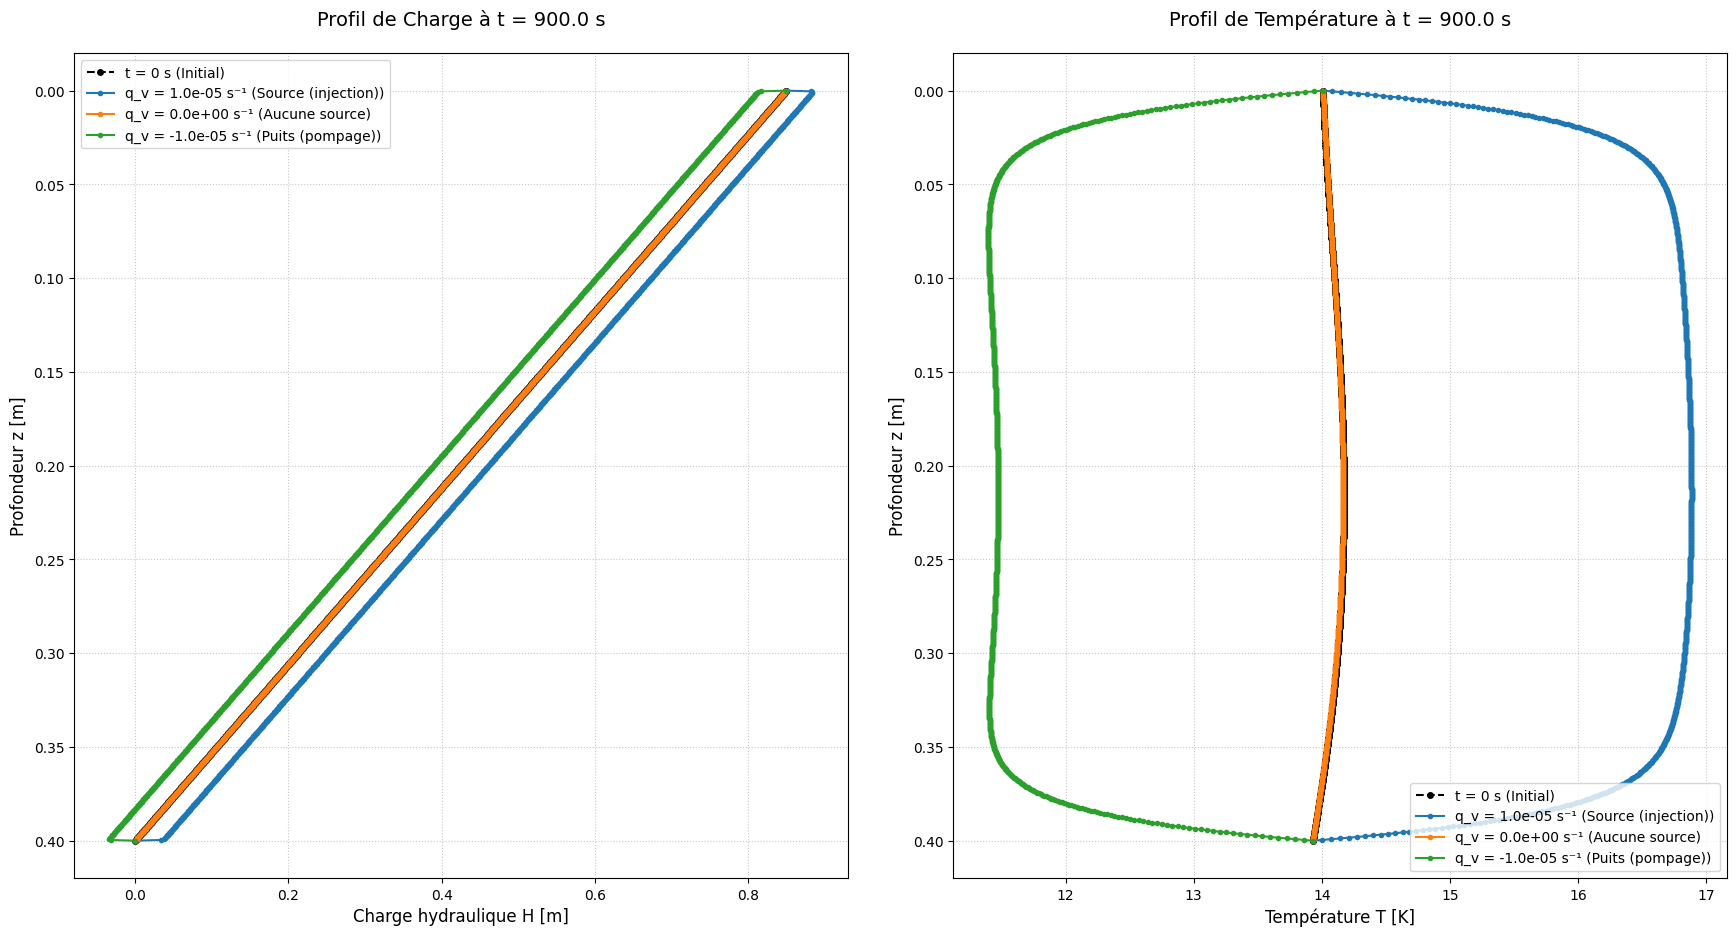

In [34]:
# --- 4. Simulation couplée et Visualisation ---

print("Lancement des simulations couplées (hydraulique et thermique)...")

# Création de la figure avec deux sous-graphiques côte à côte
# ax1 pour la charge H, ax2 pour la température T
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# --- Graphique 1 : Charge Hydraulique ---
ax1.plot(H_initial, z_coords, 'o--', label='t = 0 s (Initial)', color='black', markersize=4, zorder=1)

# --- Graphique 2 : Température ---
ax2.plot(T_initial-273.15, z_coords, 'o--', label='t = 0 s (Initial)', color='black', markersize=4, zorder=1)


# Boucle sur les différentes valeurs de q_v
for label, q_v_val in q_values.items():
    
    # --- Étape A : Simulation Hydraulique ---
    H_final, _, _ = solve_H_onestep(
        H_j=H_initial,
        K=K, Ss=Ss, dt=dt, dz=dz, alpha=alpha,
        q=q_v_val,
        H_riv=H_riv, H_aq=H_aq
    )
    
    # --- Étape B : Calcul de la Vitesse de Darcy ---
    # On calcule le gradient de la charge hydraulique dH/dz.
    # np.gradient est une méthode robuste qui utilise des différences finies centrées.
    # Vérification des unités : q = -K * dH/dz -> [m/s] * [m/m] = [m/s]. C'est correct. ✅
    hydraulic_gradient = np.gradient(H_final, dz)
    q_darcy = -K * hydraulic_gradient
    
    # --- Étape C : Simulation Thermique ---
    T_final, _, _ = solve_T_onestep(
        T_j=T_initial,
        q_darcy=q_darcy,
        q_v=q_v_val,
        rho_m_cm=rho_m_cm,
        rho_w_cw=rho_w_cw,
        lambda_m=lambda_m,
        dt=dt, dz=dz, alpha=alpha,
        T_riv=T_riv, T_aq=T_aq
    )
    
    # --- Étape D : Ajout des profils finaux aux graphiques ---
    # zorder=2 permet de s'assurer que ces courbes sont dessinées par-dessus le profil initial.
    
    # Tracé du profil de charge final
    plot_label_H = f'q_v = {q_v_val:.1e} s⁻¹ ({label})'
    ax1.plot(H_final, z_coords, 'o-', label=plot_label_H, markersize=3, zorder=2)
    
    # Tracé du profil de température final
    plot_label_T = f'q_v = {q_v_val:.1e} s⁻¹ ({label})'
    ax2.plot(T_final-273.15, z_coords, 'o-', label=plot_label_T, markersize=3, zorder=2)

print("Simulations terminées.")

# --- Configuration du graphique 1 (Charge H) ---
ax1.set_xlabel('Charge hydraulique H [m]', fontsize=12)
ax1.set_ylabel('Profondeur z [m]', fontsize=12)
ax1.set_title(f'Profil de Charge à t = {dt} s', fontsize=14, pad=20)
ax1.invert_yaxis()
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# --- Configuration du graphique 2 (Température T) ---
ax2.set_xlabel('Température T [K]', fontsize=12)
ax2.set_ylabel('Profondeur z [m]', fontsize=12)
ax2.set_title(f'Profil de Température à t = {dt} s', fontsize=14, pad=20)
ax2.invert_yaxis()
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

# Ajustement de la mise en page et affichage
plt.tight_layout(pad=3.0)
plt.show()